In [ ]:
!pip install pytorch_lightning

# Import Libraries

In [ ]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchmetrics import Accuracy

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [ ]:
batch_size = 64
img_size = 224

data_dir = '/content/drive/MyDrive/CV_project/data/SKIN/test'

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224",
                                                         do_rescale=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
from torchvision.transforms import (
    # CenterCrop,
    Compose,
    # Normalize,
    # RandomHorizontalFlip,
    # RandomResizedCrop,
    Resize,
    ToTensor,
)

# normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transforms = Compose(
        [
            Resize(img_size),
            ToTensor(),
        ]
    )

In [ ]:
!rm -r /content/drive/MyDrive/CV_project/data/SKIN/test/.ipynb_checkpoints

In [ ]:
dataset = datasets.ImageFolder(data_dir, transforms)

In [ ]:
len(dataset)

38081

In [ ]:
class Collator:
   def __init__(self, feature_extractor):
      self.feature_extractor = feature_extractor

   def __call__(self, batch):
      encodings = self.feature_extractor([x[0] for x in batch],
      return_tensors='pt')
      encodings['labels'] = torch.tensor([x[1] for x in batch],
      dtype=torch.long)
      return encodings

collator = Collator(feature_extractor)

In [ ]:
train_size = int(len(dataset)*0.8)
valid_size = len(dataset) - train_size
print(train_size, valid_size)

30464 7617


In [ ]:
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          collate_fn=collator,
                                          shuffle=True,
                                          num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          collate_fn=collator,
                                          shuffle=True,
                                          num_workers=2)

In [ ]:
id2label = {}
for i, class_name in enumerate(dataset.classes):
  id2label[str(i)] = class_name
print(dataset.class_to_idx)
print(id2label)

{'A1_구진_플라크': 0, 'A2_비듬_각질_상피성잔고리': 1, 'A3_태선화_과다색소침착': 2, 'A4_농포_여드름': 3, 'A5_미란_궤양': 4, 'A6_결절_종괴': 5, '무증상': 6}
{'0': 'A1_구진_플라크', '1': 'A2_비듬_각질_상피성잔고리', '2': 'A3_태선화_과다색소침착', '3': 'A4_농포_여드름', '4': 'A5_미란_궤양', '5': 'A6_결절_종괴', '6': '무증상'}


In [ ]:
def imshow(img):

    img = img.numpy().transpose((1, 2, 0))

    mean = feature_extractor.image_mean
    std = feature_extractor.image_std
    img = std * img + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor(0)


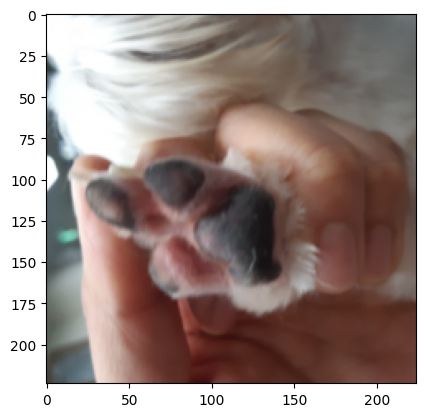

In [ ]:
for data in valid_loader:
    print(data['labels'][0])
    imshow(data['pixel_values'][0])
    break

# Load Pre-trained Model

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224",
                                               do_rescale=False)
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(id2label),
    label2id=dataset.class_to_idx,
    id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset.classes

['A1_구진_플라크',
 'A2_비듬_각질_상피성잔고리',
 'A3_태선화_과다색소침착',
 'A4_농포_여드름',
 'A5_미란_궤양',
 'A6_결절_종괴',
 '무증상']

# Model Training

In [ ]:
class ViTClassifier(pl.LightningModule):

   def __init__(self, model, lr: float = 2e-5, num_classes=2, **kwargs):
       super().__init__()
       self.save_hyperparameters('lr', *list(kwargs))
       self.model = model
       self.forward = self.model.forward
       self.acc = Accuracy(task="multiclass", num_classes=num_classes)

   def training_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"train_loss", outputs.loss)
       acc = self.acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"train_acc", acc, prog_bar=True)
       return outputs.loss

   def validation_step(self, batch, batch_idx):
       outputs = self(**batch)
       self.log(f"val_loss", outputs.loss)
       acc = self.acc(outputs.logits.argmax(1), batch['labels'])
       self.log(f"val_acc", acc, prog_bar=True)
       return outputs.loss

   def configure_optimizers(self):
       return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay = 0.00025)

In [ ]:
pl.seed_everything(42)
classifier = ViTClassifier(model, lr=2e-5, num_classes=len(dataset.classes))

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
classifier

ViTClassifier(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (i

In [ ]:
for i, (name, param) in enumerate(classifier.named_parameters()):
    if 'classifier' in name:
      print(i, name)
      break

    param.requires_grad = False

198 model.classifier.weight


In [ ]:
for i, (name, param) in enumerate(classifier.named_parameters()):
    if param.requires_grad:
      print(i, name)

198 model.classifier.weight
199 model.classifier.bias


In [ ]:
from IPython.display import clear_output

class MetricsPlotter(pl.Callback):

    def __init__(self):
        super().__init__()
        self.epoch = 0
        self.metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def on_validation_epoch_end(self, trainer, pl_module):

        for key in self.metrics.keys():
            value = trainer.logged_metrics.get(key, 0)
            if isinstance(value, torch.Tensor):
                value = value.cpu().numpy().item()
            self.metrics[key].append(value)

        if self.epoch != 0:
            clear_output(wait=True)
            print("epoch {} train acc {} validation acc {}".format(self.epoch,
                                                                   self.metrics['train_acc'][-1],
                                                                   self.metrics['val_acc'][-1]))
            self.loss_epoch_curve()

        self.epoch += 1

    def loss_epoch_curve(self):

        figure, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].plot(self.metrics['train_loss'])
        ax[0].plot(self.metrics['val_loss'])
        ax[0].set_title('Loss-Epoch curve')
        ax[0].set_ylabel('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['train', 'val'], loc='upper right')

        ax[1].plot(self.metrics['train_acc'])
        ax[1].plot(self.metrics['val_acc'])
        ax[1].set_title('Model Accuracy')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['train', 'val'], loc='lower right')

        plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/CV_project/skin_model'

checkpoint = ModelCheckpoint(
    monitor = "val_loss",
    mode = "min",
    dirpath = model_path,
    filename = "sample-vit_{epoch:02d}-{val_loss:.2f}",
    save_weights_only = False,
    save_top_k = 2
)

In [ ]:
trainer = pl.Trainer(precision='16-mixed', max_epochs=3,
                    callbacks=[checkpoint, MetricsPlotter()])

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
trainer.fit(classifier, train_loader, valid_loader)

In [ ]:
# pl model.to_onnx

# Inference

In [ ]:
def inference(img_path):

    img = Image.open(img_path)
    encoding = feature_extractor(images=img, return_tensors='pt')

    outputs = classifier(encoding['pixel_values'])
    result = outputs.logits.softmax(1)
    result_dict = {}

    for i, value in enumerate(result[0].tolist()):
        result_dict[id2label[str(i)]] = value

    result = sorted(result_dict.items(), key=lambda x:x[1], reverse=True)

    return result

In [ ]:
file_path = ''
result = inference(file_path)
print(f'{result[0][0]}일 확률이 {int(result[0][1]*100)}%, {result[1][0]}일 확률이 {int(result[1][1]*100)}% 입니다.')